In [1]:
import pandas as pd
import numpy as np
import talib
import pandas_profiling as pdp
import sweetviz as sv

import os
import sys
from pygam import s, LinearGAM
import category_encoders as ce
from typing import List, Dict

import matplotlib.pyplot as plt
import seaborn as sns

import ptitprince
from matplotlib_venn import venn2
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

from common_module.utils.plot import (
    plot_venn,
    plot_histogram,
    plot_raincloud,
    plot_heatmap,
    plot_histgram_for_valid,
    plot_lineargam,
    plot_feature_importance_for_valid
)
from common_module.utils.summarize import (
    get_pandas_profiling,
    get_sweetviz_report
)
from common_module.utils.preprocessor import (
    OrdinalEncodingBlock,
    CountEncodingBlock,
    GroupingBlock
)
from common_module.utils.format_df import format_df
from common_module.utils.utils import (
    reduce_mem_usage,
    save_pickle,
    load_pickle
)
from common_module.utils.metrics import (
    calc_MAE,
    calc_MSE,
    calc_RMSE,
    calc_RMSLE
)

from probspace_fudosan.modules.config_manager import ConfigManager
from probspace_fudosan.modules.preprocessor import ConcatTrainTestDf
from probspace_fudosan.modules.features import FeatureEngineering
from probspace_fudosan.modules.validator import (
    make_KFold,
    add_true_for_valid
)
from probspace_fudosan.modules.train_module import (
    TrainLGBModule,
    TrainCABModule,
    TrainXGBModule
)
from probspace_fudosan.modules.predict import PredictModule
from probspace_fudosan.modules.adversarial_validator import AdversarialValidator


sys.path.append("../")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/saitouteruaki/.local/share/virtualenvs/data_science-EJAMj-NW/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Config

In [2]:
config = ConfigManager(config_path="../config/setting.yaml")

## data読み込み

In [3]:
df_train_origin = pd.read_csv(os.path.join(config.input_path, "train_data.csv"), encoding="utf-8-sig")
df_test_origin = pd.read_csv(os.path.join(config.input_path, "test_data.csv"), encoding="utf-8-sig")
df_published_origin = pd.read_csv(os.path.join(config.input_path, "published_land_price.csv"), encoding="utf-8-sig")

print("■ train data", "="*30)
display(df_train_origin.shape)
display(df_train_origin.head(1))

print("■ test data", "="*30)
display(df_test_origin.shape)
display(df_test_origin.head(1))

print("■ published", "="*30)
display(df_published_origin.shape)
display(df_published_origin.head(1))

■ train data ==============================


(356344, 28)

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,1,２ＬＤＫ,55,NaN,NaN,NaN,昭和59年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2017年第４四半期,改装済,NaN,66.0


■ test data ==============================


(34844, 27)

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,3,１ＬＤＫ,35,NaN,NaN,NaN,昭和60年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,700.0,2018年第４四半期,未改装,NaN


■ published ==============================


(2602, 116)

,id,経度,緯度,所在地コード,用途,連番,年次,前年所在地コード,前年用途,前年連番,市区町村名,住居表示,行政,地積,利用の現況,利用状況表示,建物構造,施設,形状区分,間口（比率）,奥行（比率）,階層（地上）,階層（地下）,前面道路区分,前面道路の方位区分,前面道路の幅員,前面道路の駅前区分,前面道路の舗装状況,側道区分,側道方位区分,交通施設との近接区分,周辺の土地の利用の現況,駅名,駅距離,用途区分,防火区分,都市計画区分,森林区分,公園区分,建蔽率,容積率,共通地点区分,選定年次ビット,Ｓ５８価格,Ｓ５９価格,Ｓ６０価格,Ｓ６１価格,Ｓ６２価格,Ｓ６３価格,Ｈ１価格,Ｈ２価格,Ｈ３価格,Ｈ４価格,Ｈ５価格,Ｈ６価格,Ｈ７価格,Ｈ８価格,Ｈ９価格,Ｈ１０価格,Ｈ１１価格,Ｈ１２価格,Ｈ１３価格,Ｈ１４価格,Ｈ１５価格,Ｈ１６価格,Ｈ１７価格,Ｈ１８価格,Ｈ１９価格,Ｈ２０価格,Ｈ２１価格,Ｈ２２価格,Ｈ２３価格,Ｈ２４価格,Ｈ２５価格,Ｈ２６価格,Ｈ２７価格,Ｈ２８価格,Ｈ２９価格,Ｈ３０価格,Ｈ３１価格,属性移動Ｓ５９,属性移動Ｓ６０,属性移動Ｓ６１,属性移動Ｓ６２,属性移動Ｓ６３,属性移動Ｈ１,属性移動Ｈ２,属性移動Ｈ３,属性移動Ｈ４,属性移動Ｈ５,属性移動Ｈ６,属性移動Ｈ７,属性移動Ｈ８,属性移動Ｈ９,属性移動Ｈ１０,属性移動Ｈ１１,属性移動Ｈ１２,属性移動Ｈ１３,属性移動Ｈ１４,属性移動Ｈ１５,属性移動Ｈ１６,属性移動Ｈ１７,属性移動Ｈ１８,属性移動Ｈ１９,属性移動Ｈ２０,属性移動Ｈ２１,属性移動Ｈ２２,属性移動Ｈ２３,属性移動Ｈ２４,属性移動Ｈ２５,属性移動Ｈ２６,属性移動Ｈ２７,属性移動Ｈ２８,属性移動Ｈ２９,属性移動Ｈ３０,属性移動Ｈ３１
0,1,500891.116,123138.601,13364,0,1,2019,13364,0,1,神津島,東京都 神津島村９９５番,13364,224,10000000000000000,_,W2,101,_,10,12,2,0,村道,南,22,_,_,_,_,_,一般住宅のほか民宿、店舗等が混在する住宅地域,キャンドゥ前,460,_,_,非線引,_,_,70,200,False,0000000000011111111111111111111111111,0,0,0,0,0,0,0,0,0,0,0,7600,7600,7600,7600,7600,7600,7600,7500,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,0,0,0,0,0,0,0,0,0,0,40000000000000,10000000000000,10000000000000,10000000000000,10000001000001,10000001000001,10000000000011,10000000000000,10000000000000,10000000000000,10000100000000,10000000000001,10000000000000,10000000000000,10000000000000,10000010000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000000


## 前処理

In [4]:
# publishedデータのリネーム
df_published = df_published_origin.copy()
df_published = df_published.rename(columns=config.published_rename_dict)

In [5]:
# test & train データの結合
ins_concat = ConcatTrainTestDf(train=df_train_origin, test=df_test_origin, with_log1p_y=True)
df_all = ins_concat.concat_df()
print(f"df_train_origin: {df_train_origin.shape}")
print(f"df_test_origin: {df_test_origin.shape}")
print(f"df_all: {df_all.shape}")

df_train_origin: (356344, 28)
df_test_origin: (34844, 27)
df_all: (391188, 30)


In [6]:
ins_feat = FeatureEngineering()
df_all = ins_feat.fix_torihiki_jiten(input_df=df_all)
df_all = ins_feat.fix_menseki(input_df=df_all)
df_all = ins_feat.fix_moyori_eki_kyori(input_df=df_all)
df_all = ins_feat.create_madori_features(input_df=df_all)
df_all = ins_feat.fix_maguchi(input_df=df_all)
df_all = ins_feat.fix_nobeyuka_menseki(input_df=df_all)
df_all = ins_feat.fix_create_kenchiku_nensu(input_df=df_all)
df_all = ins_feat.fix_moyori_eki_meisho(input_df=df_all)
df_all = ins_feat.create_shichoson(input_df=df_all)
df_all = ins_feat.fix_create_tatemono_kouzo(input_df=df_all)
df_all = ins_feat.fix_create_yoto(input_df=df_all)
df_all = ins_feat.fix_create_torihiki_jizyo(input_df=df_all)
df_all = ins_feat.create_combination_features(input_df=df_all)

# dtypeを修正
df_all = reduce_mem_usage(df_all)
# dtypeのフォーマット
df_all = format_df(df_all, dtype_definition=config.feature_columns)

finish fix_torihiki_jiten
finish fix_menseki
finish fix_moyori_eki_kyori
finish create_madori_features
finish fix_maguchi
finish fix_nobeyuka_menseki
finish fix_create_kenchiku_nensu
finish fix_moyori_eki_meisho
finish create_shichoson
finish fix_create_tatemono_kouzo
finish fix_create_yoto
finish fix_create_torihiki_jizyo
finish create_combination_features
Memory usage of dataframe is 199.96 MB
Memory usage after optimization is: 36.72 MB
Decreased by 81.6%


## Adversarial Validatoconfigr

In [7]:
ins_adv = AdversarialValidator()
df = ins_adv.create_AdvVal_target_column(df_all=df_all, config=config)
model_set, importance_set, evals_set, df_val_all = ins_adv.exec_cross_validation(df_all=df, cv_method="KFold", config=config)

start cv_num=0 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.988546
pred AdvVal_y ...
start cv_num=1 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.988086
pred AdvVal_y ...
start cv_num=2 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.987773
pred AdvVal_y ...
start cv_num=3 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.988538
pred AdvVal_y ...
start cv_num=4 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.987921
pred AdvVal_y ...


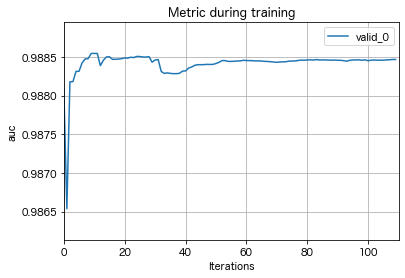

In [14]:
import lightgbm as lgb
ax = lgb.plot_metric(evals_set[f"AdvVal_y_0"], metric="auc")
plt.show()

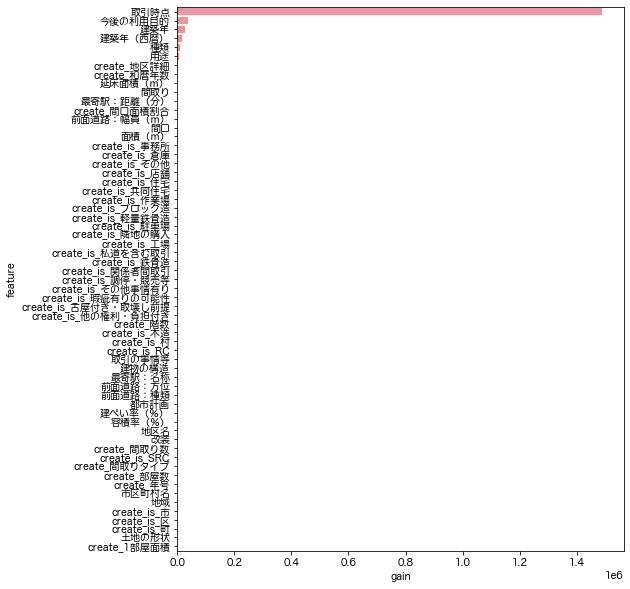

In [16]:
df_imp_ = importance_set[f"AdvVal_y_0"].sort_values("gain", ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(x=df_imp_["gain"], y=df_imp_["feature"]);

In [17]:
# trainとtestに分ける
df_train = df_all[df_all["data_type"] == "train"].copy()
df_test = df_all[df_all["data_type"] == "test"].copy()

print(df_train["取引時点"].min(), df_train["取引時点"].max())
print(df_test["取引時点"].min(), df_test["取引時点"].max())

2006.0 2018.0
2018.0 2019.0


- 取引時点でtrainとtestを分類できるため、取引時点は学習に使用しない

## 学習

In [18]:
model_set = {}
importance_set = {}
evals_set = {}
df_val_set = {}
df_test_set = {}
df_val_list = []
df_test_list = []

# trainとtestに分ける
df_train = df_all[df_all["data_type"] == "train"].copy()
df_test = df_all[df_all["data_type"] == "test"].copy()

print(f"train {config.target} ...")
# インスタンス生成
ins_lgb_train = TrainLGBModule(config=config, target=config.target)
ins_lgb_val_pred = PredictModule(config=config, target=config.target, model_type="lightgbm", is_test=False, clip=False)
ins_lgb_test_pred = PredictModule(config=config, target=config.target, model_type="lightgbm", is_test=True, clip=False)

# kfolds
folds_idx = make_KFold(
    train_x=df_train,
    train_y=df_train[config.target],
    n_splits=config.n_splits,
    random_state=config.random_state
)
# 学習
for cv_num, (tr_idx, va_idx) in enumerate(folds_idx):
    df_train_t, df_train_v = df_train.loc[tr_idx, :], df_train.loc[va_idx, :]
    model_lgb, df_imp_lgb, evals_result_lgb = ins_lgb_train.train_model(df_train=df_train_t, df_val=df_train_v, have_weight=False)
    # dataset への保存
    model_set[f"{config.target}_{cv_num}"] = model_lgb
    importance_set[f"{config.target}_{cv_num}"] = df_imp_lgb
    evals_set[f"{config.target}_{cv_num}"] = evals_result_lgb
    # validationデータを予測
    df_val_pred_lgb = ins_lgb_val_pred.predict(model=model_lgb, test_df=df_train_v, cv_num=cv_num)
    df_val = add_true_for_valid(df_val=df_train_v, df_val_pred=df_val_pred_lgb, target=config.target, cv_num=cv_num, config=config)
    use_cols = [f"true_{config.target}", f"pred_{config.target}"]
    df_val[f"true_expm1y"] = np.expm1(df_val[f"true_{config.target}"])
    df_val[f"pred_expm1y"] = np.expm1(df_val[f"pred_{config.target}"])
    rmse_score = calc_RMSE(
        y_true=df_val["true_expm1y"],
        y_pred=df_val["pred_expm1y"]
    )
    print(f"■ target_col=expm1y | cv_num={cv_num} | rmse_score={rmse_score:.4f}")
    df_val_set[f"expm1y_{cv_num}"] = df_val
    df_val_list.append(df_val)
    # testデータを予測
    df_test_pred_lgb = ins_lgb_test_pred.predict(model=model_lgb, test_df=df_test, cv_num=cv_num)
    df_test_pred_lgb[f"pred_expm1y"] = np.expm1(df_test_pred_lgb[f"pred_{config.target}"])
    df_test_set[f"expm1y_{cv_num}"] = df_test_pred_lgb
    df_test_list.append(df_test_pred_lgb)
    print("=" * 70)

# validationデータ全体のcvスコア
print("~" * 70)
df_valid_results = pd.concat(df_val_list, ignore_index=True, sort=False)
rmse_score_all = calc_RMSE(
    y_true=df_valid_results[f"true_expm1y"],
    y_pred=df_valid_results[f"pred_expm1y"]
)
print(f"■ target_col=expm1y | rmse_score={rmse_score_all:.4f}")

train log1p_y ...
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.281865
[2000]	valid_0's rmse: 0.275685
[3000]	valid_0's rmse: 0.273543
[4000]	valid_0's rmse: 0.272529
[5000]	valid_0's rmse: 0.272063
Early stopping, best iteration is:
[5367]	valid_0's rmse: 0.27195
pred log1p_y ...
■ target_col=expm1y | cv_num=0 | rmse_score=197.5335
pred log1p_y ...
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.282631
[2000]	valid_0's rmse: 0.276412
[3000]	valid_0's rmse: 0.274076
[4000]	valid_0's rmse: 0.272914
[5000]	valid_0's rmse: 0.272288
[6000]	valid_0's rmse: 0.271959
Early stopping, best iteration is:
[6691]	valid_0's rmse: 0.271816
pred log1p_y ...
■ target_col=expm1y | cv_num=1 | rmse_score=280.8914
pred log1p_y ...
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.280626
[2000]	valid_0's rmse: 0.275036
[3000]	valid_0's rmse: 0.273085
[4000]	valid_0's rmse: 0.272153
[5000]	va

In [19]:
# cv回数分のtest結果を平均する
df_test_results = pd.concat(df_test_list, ignore_index=True, sort=False)
df_test_results_mean = df_test_results.groupby("id", as_index=False)[f"pred_expm1y"].mean()
df_test_results_mean.columns = ["id", "y"]
df_test_results_mean = df_test_results_mean.sort_values("id")
df_test_results_mean.to_csv(os.path.join(config.output_path, "submission_1.csv"), encoding="utf-8-sig", index=False)

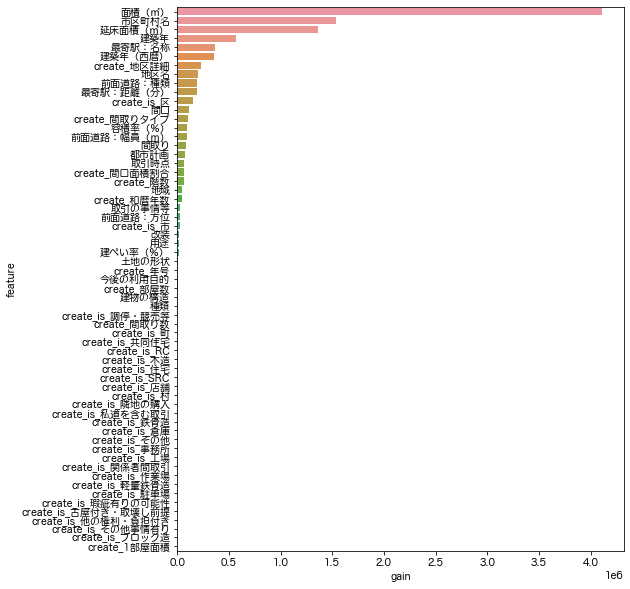

In [20]:
df_imp_ = df_imp_lgb.sort_values("gain", ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(x=df_imp_["gain"], y=df_imp_["feature"]);

## 補足
- lightgbmのvalid_setsについて
    - valid_sets=[train_data, val_data]でもvalid_sets=[val_data]でも結果に差異なし。

In [7]:
model_set = {}
importance_set = {}
evals_set = {}
df_val_set = {}
df_test_set = {}
df_val_list = []
df_test_list = []

# trainとtestに分ける
df_train = df_all[df_all["data_type"] == "train"].copy()
df_test = df_all[df_all["data_type"] == "test"].copy()

print(f"train {config.target} ...")
# インスタンス生成
ins_lgb_train = TrainLGBModule(config=config, target=config.target)
ins_lgb_val_pred = PredictModule(config=config, target=config.target, model_type="lightgbm", is_test=False, clip=False)
ins_lgb_test_pred = PredictModule(config=config, target=config.target, model_type="lightgbm", is_test=True, clip=False)

# kfolds
folds_idx = make_KFold(
    train_x=df_train,
    train_y=df_train[config.target],
    n_splits=config.n_splits,
    random_state=config.random_state
)
# 学習
for cv_num, (tr_idx, va_idx) in enumerate(folds_idx):
    df_train_t, df_train_v = df_train.loc[tr_idx, :], df_train.loc[va_idx, :]
    model_lgb, df_imp_lgb, evals_result_lgb = ins_lgb_train.train_model(df_train=df_train_t, df_val=df_train_v, have_weight=False)
    # dataset への保存
    model_set[f"{config.target}_{cv_num}"] = model_lgb
    importance_set[f"{config.target}_{cv_num}"] = df_imp_lgb
    evals_set[f"{config.target}_{cv_num}"] = evals_result_lgb
    # validationデータを予測
    df_val_pred_lgb = ins_lgb_val_pred.predict(model=model_lgb, test_df=df_train_v, cv_num=cv_num)
    df_val = add_true_for_valid(df_val=df_train_v, df_val_pred=df_val_pred_lgb, target=config.target, cv_num=cv_num, config=config)
    use_cols = [f"true_{config.target}", f"pred_{config.target}"]
    df_val[f"true_expm1y"] = np.expm1(df_val[f"true_{config.target}"])
    df_val[f"pred_expm1y"] = np.expm1(df_val[f"pred_{config.target}"])
    rmse_score = calc_RMSE(
        y_true=df_val["true_expm1y"],
        y_pred=df_val["pred_expm1y"]
    )
    print(f"■ target_col=expm1y | cv_num={cv_num} | rmse_score={rmse_score:.4f}")
    df_val_set[f"expm1y_{cv_num}"] = df_val
    df_val_list.append(df_val)
    # testデータを予測
    df_test_pred_lgb = ins_lgb_test_pred.predict(model=model_lgb, test_df=df_test, cv_num=cv_num)
    df_test_pred_lgb[f"pred_expm1y"] = np.expm1(df_test_pred_lgb[f"pred_{config.target}"])
    df_test_set[f"expm1y_{cv_num}"] = df_test_pred_lgb
    df_test_list.append(df_test_pred_lgb)
    print("=" * 70)

# validationデータ全体のcvスコア
print("~" * 70)
df_valid_results = pd.concat(df_val_list, ignore_index=True, sort=False)
rmse_score_all = calc_RMSE(
    y_true=df_valid_results[f"true_expm1y"],
    y_pred=df_valid_results[f"pred_expm1y"]
)
print(f"■ target_col=expm1y | rmse_score={rmse_score_all:.4f}")

train log1p_y ...
Training until validation scores don't improve for 100 rounds
[1000]	train's rmse: 0.262258	valid's rmse: 0.281865
[2000]	train's rmse: 0.246036	valid's rmse: 0.275685
[3000]	train's rmse: 0.235456	valid's rmse: 0.273543
[4000]	train's rmse: 0.227559	valid's rmse: 0.272529
[5000]	train's rmse: 0.221088	valid's rmse: 0.272063
Early stopping, best iteration is:
[5367]	train's rmse: 0.218984	valid's rmse: 0.27195
pred log1p_y ...
■ target_col=expm1y | cv_num=0 | rmse_score=197.5335
pred log1p_y ...
Training until validation scores don't improve for 100 rounds
[1000]	train's rmse: 0.262716	valid's rmse: 0.282631
[2000]	train's rmse: 0.246978	valid's rmse: 0.276412
[3000]	train's rmse: 0.236901	valid's rmse: 0.274076
[4000]	train's rmse: 0.228975	valid's rmse: 0.272914
[5000]	train's rmse: 0.22225	valid's rmse: 0.272288
[6000]	train's rmse: 0.21654	valid's rmse: 0.271959
Early stopping, best iteration is:
[6691]	train's rmse: 0.21303	valid's rmse: 0.271816
pred log1p_y ...